In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import matplotlib.pyplot as plt

# --- 中文顯示設定 ---
# 加上這兩行來正常顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 指定支援中文的字體
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題
# ---

# ... 接著是您其他的 import 和程式碼 ...
# import os
# import numpy as np
# from PIL import Image

正在載入 COCO 標註檔，請稍候...
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
載入完成！
選取的圖片資訊: {'license': 1, 'file_name': '000000453708.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000453708.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-19 19:36:47', 'flickr_url': 'http://farm6.staticflickr.com/5107/5559810184_63a5d322fc_z.jpg', 'id': 453708}

在這張圖片上找到了 14 個物件實例。
正在繪製實例分割遮罩...


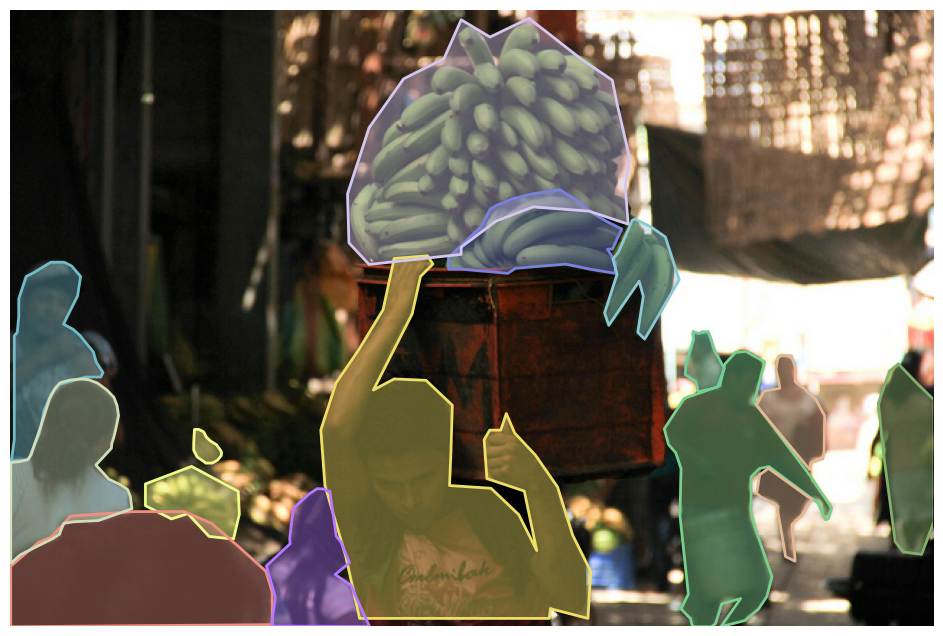

In [1]:
import os
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# --- 步驟 1: 探索與視覺化 COCO 資料集 ---

# --- 1. 設定路徑 ---
# 【請確認】路徑是否正確
COCO_DIR = './coco2017/'
IMG_DIR = os.path.join(COCO_DIR, 'val2017')
ANN_FILE = os.path.join(COCO_DIR, 'annotations', 'instances_val2017.json')

# --- 2. 使用 pycocotools 載入標註檔 ---
# 初始化 COCO api
# 這一步會將 json 檔案讀取到記憶體中，並建立索引，方便查詢
print("正在載入 COCO 標註檔，請稍候...")
coco = COCO(ANN_FILE)
print("載入完成！")

# --- 3. 隨機選取一張圖片並顯示 ---
# 取得資料集中所有圖片的 ID
img_ids = coco.getImgIds()

# 隨機選取一張圖片的 ID
# np.random.choice(img_ids) 會從所有 ID 中隨機選一個
selected_img_id = np.random.choice(img_ids)

# 【關鍵修正】將 selected_img_id 放入一個列表中再傳入
img_info = coco.loadImgs([selected_img_id])[0]
print(f"選取的圖片資訊: {img_info}")

# 載入圖片
img_path = os.path.join(IMG_DIR, img_info['file_name'])
image = Image.open(img_path).convert('RGB')

# --- 4. 取得並顯示該圖片的所有實例分割標註 ---
# 取得這張圖片上所有標註的 ID
ann_ids = coco.getAnnIds(imgIds=img_info['id'])
# 根據 ID 載入標註的詳細內容
anns = coco.loadAnns(ann_ids)

print(f"\n在這張圖片上找到了 {len(anns)} 個物件實例。")

# --- 視覺化 ---
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')

# pycocotools 提供了方便的視覺化函式
print("正在繪製實例分割遮罩...")
coco.showAnns(anns)

plt.show()

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as T

# --- 步驟 2: 使用 torchvision 的 CocoDetection ---

# 1. 定義一個簡單的 transform，先只將圖片轉換為 Tensor
# (注意：torchvision 內建的 CocoDetection 對於複雜的資料增強(augmentation)處理比較麻煩，
#  我們先用最簡單的方式來搭建流程，之後可以再深入優化)
transforms = T.Compose([
    T.ToTensor()
])

# 2. 實例化 CocoDetection Dataset
# root 是圖片資料夾的路徑
# annFile 是標註檔 .json 的路徑
coco_dataset = torchvision.datasets.CocoDetection(root=IMG_DIR, 
                                                 annFile=ANN_FILE, 
                                                 transform=transforms)

print(f"成功使用 CocoDetection 載入資料集，總共有 {len(coco_dataset)} 張圖片。")


# 3. 建立 DataLoader
# 我們依然需要 collate_fn 來處理每張圖物件數量不同的問題
def collate_fn(batch):
    return tuple(zip(*batch))

# 為了快速測試，我們先用一小部分資料
# torch.utils.data.Subset 可以幫我們從一個大的資料集中切分出一小部分
# 【關鍵修正】在最後加上 .tolist() 將 Tensor 轉換為 Python 列表
subset_indices = torch.randperm(len(coco_dataset))[:500].tolist()
coco_subset = torch.utils.data.Subset(coco_dataset, subset_indices)


data_loader = DataLoader(
    coco_subset,
    batch_size=2, # Mask R-CNN 模型很大，batch size 不能設太大
    shuffle=True,
    collate_fn=collate_fn
)

print(f"\n成功建立 DataLoader，將使用 {len(coco_subset)} 張圖片進行測試。")


# 4. 從 DataLoader 中取出一批資料看看
images, targets = next(iter(data_loader))
print("\n--- 從 DataLoader 取出的一批資料 ---")
print(f"圖片 (Images) 的類型: a list of {type(images[0])}")
print(f"圖片 Tensor 的形狀: {images[0].shape}")
print(f"\n標註 (Targets) 的類型: a list of {type(targets[0])}")
print(f"第一個標註的內容 (部分):")
# targets 是一個 list of lists of dicts，我們看第一張圖的第一個物件
print(targets[0][0])

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
成功使用 CocoDetection 載入資料集，總共有 5000 張圖片。

成功建立 DataLoader，將使用 500 張圖片進行測試。

--- 從 DataLoader 取出的一批資料 ---
圖片 (Images) 的類型: a list of <class 'torch.Tensor'>
圖片 Tensor 的形狀: torch.Size([3, 480, 640])

標註 (Targets) 的類型: a list of <class 'list'>
第一個標註的內容 (部分):
{'segmentation': [[130.52, 462.41, 111.1, 389.06, 125.12, 342.68, 253.48, 288.75, 313.89, 267.18, 412.04, 238.05, 446.56, 251.0, 464.9, 239.13, 529.62, 238.05, 587.87, 266.1, 616.99, 299.54, 579.24, 386.91, 523.15, 469.96, 412.04, 468.88, 235.15, 472.12, 136.99, 468.88, 126.2, 459.18]], 'area': 91303.13735, 'iscrowd': 0, 'image_id': 329080, 'bbox': [111.1, 238.05, 505.89, 234.07], 'category_id': 65, 'id': 318591}


In [3]:
import torchvision
# 【關鍵修正】匯入 V1 版本的權重物件
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# --- 步驟 3: 準備預訓練的 Mask R-CNN 模型 ---

# --- 【最終修正版】的函式 ---
def get_model_instance_segmentation(num_classes):
    # 載入一個在 COCO 上預訓練好的 Mask R-CNN 模型
    # 【關鍵修正】使用 V1 版本的權重，並明確指定 COCO_V1
    weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
    model = maskrcnn_resnet50_fpn(weights=weights)

    # 1. 替換框線預測頭 (Box Predictor) - (此處邏輯不變)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 2. 替換遮罩預測頭 (Mask Predictor) - (此處邏輯不變)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      num_classes)
    return model

# --- 建立模型 ---
# COCO 有 91 個類別，但我們的資料集中可能沒有這麼多
# 我們需要知道我們這個 subset 中實際有多少個類別
# 為了簡化，我們先假設我們的目標是 COCO 的前 10 個類別 + 1 個背景
num_classes = 11 

model = get_model_instance_segmentation(num_classes)
model.to(DEVICE) # 將模型移動到 GPU

print("Mask R-CNN 模型準備完成！")
# 您可以印出 model.roi_heads 來看看 box_predictor 和 mask_predictor 的變化
# print(model.roi_heads)

Mask R-CNN 模型準備完成！


In [4]:
import torch
from torch.utils.data import DataLoader
import torchvision

# --- 步驟 4: 訓練 Mask R-CNN 模型 ---

# --- 1. 準備資料 ---
# 我們依然需要 collate_fn
def collate_fn(batch):
    return tuple(zip(*batch))

# 簡單的 transform
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# 建立 CocoDetection Dataset
coco_dataset = torchvision.datasets.CocoDetection(root=IMG_DIR, 
                                                 annFile=ANN_FILE, 
                                                 transform=transforms)

# 建立一個小的子集來快速訓練
subset_indices = torch.randperm(len(coco_dataset))[:500].tolist()
coco_subset = torch.utils.data.Subset(coco_dataset, subset_indices)

# 建立 DataLoader
data_loader = DataLoader(
    coco_subset,
    batch_size=2, # Mask R-CNN 較大，建議 batch size 從 2 開始
    shuffle=True,
    collate_fn=collate_fn
)


# --- 2. 準備模型、優化器 ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# COCO 總共有 91 個類別，我們假設全部都用，所以 num_classes = 91 + 1 (背景)
num_classes = 92

model = get_model_instance_segmentation(num_classes)
model.to(DEVICE)

# 建立優化器
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# --- 3. 訓練迴圈 ---
# --- 【最終修正版】的訓練迴圈 ---
num_epochs = 5
print("開始訓練 Mask R-CNN 模型...")

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader:
        images = list(image.to(DEVICE) for image in images)

        # 【關鍵修正】為每一張圖片都建立一個 target，即使它是空的
        processed_targets = []
        for target_list_per_image in targets:
            d = {}
            # 檢查這張圖片是否有標註
            if not target_list_per_image:
                # 如果沒有，建立一個包含空 Tensor 的 target
                d['boxes'] = torch.empty((0, 4), dtype=torch.float32, device=DEVICE)
                d['labels'] = torch.empty((0,), dtype=torch.int64, device=DEVICE)
                d['masks'] = torch.empty((0, images[0].shape[1], images[0].shape[2]), dtype=torch.uint8, device=DEVICE)
            else:
                # 如果有，正常處理
                boxes = torch.as_tensor([ann['bbox'] for ann in target_list_per_image], dtype=torch.float32)
                boxes[:, 2:] += boxes[:, :2] # 轉換為 [x1, y1, x2, y2]
                d['boxes'] = boxes
                
                d['labels'] = torch.as_tensor([ann['category_id'] for ann in target_list_per_image], dtype=torch.int64)
                
                masks_np = [coco.annToMask(ann) for ann in target_list_per_image]
                d['masks'] = torch.as_tensor(np.array(masks_np), dtype=torch.uint8)

            # 將所有 Tensor 移動到 device
            d = {k: v.to(DEVICE) for k, v in d.items()}
            processed_targets.append(d)

        # 將 images 和 processed_targets 傳給模型 (現在它們的長度保證一致)
        loss_dict = model(images, processed_targets)

        losses = sum(loss for loss in loss_dict.values())

        # 處理 loss 可能為 NaN 的情況 (如果一個 batch 全是負樣本，loss 可能不存在)
        if torch.isnan(losses):
            continue

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        i += 1
        if (i + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {losses.item():.4f}')

print('訓練完成!')

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
開始訓練 Mask R-CNN 模型...
Epoch [1/5], Step [50/250], Loss: 2.5266
Epoch [1/5], Step [100/250], Loss: 1.8755
Epoch [1/5], Step [150/250], Loss: 2.0995
Epoch [1/5], Step [200/250], Loss: 2.7359
Epoch [1/5], Step [250/250], Loss: 0.6507
Epoch [2/5], Step [50/250], Loss: 1.2653
Epoch [2/5], Step [100/250], Loss: 1.1435
Epoch [2/5], Step [150/250], Loss: 1.1176
Epoch [2/5], Step [200/250], Loss: 0.7647
Epoch [2/5], Step [250/250], Loss: 1.3699
Epoch [3/5], Step [50/250], Loss: 1.5593
Epoch [3/5], Step [100/250], Loss: 0.9125
Epoch [3/5], Step [150/250], Loss: 0.9329
Epoch [3/5], Step [200/250], Loss: 1.2102
Epoch [3/5], Step [250/250], Loss: 1.1348
Epoch [4/5], Step [50/250], Loss: 1.4087
Epoch [4/5], Step [100/250], Loss: 0.8462
Epoch [4/5], Step [150/250], Loss: 1.0449
Epoch [4/5], Step [200/250], Loss: 1.6957
Epoch [4/5], Step [250/250], Loss: 0.5276
Epoch [5/5], Step [50/250], Loss: 0.7508
Epoch [5/5], Step 

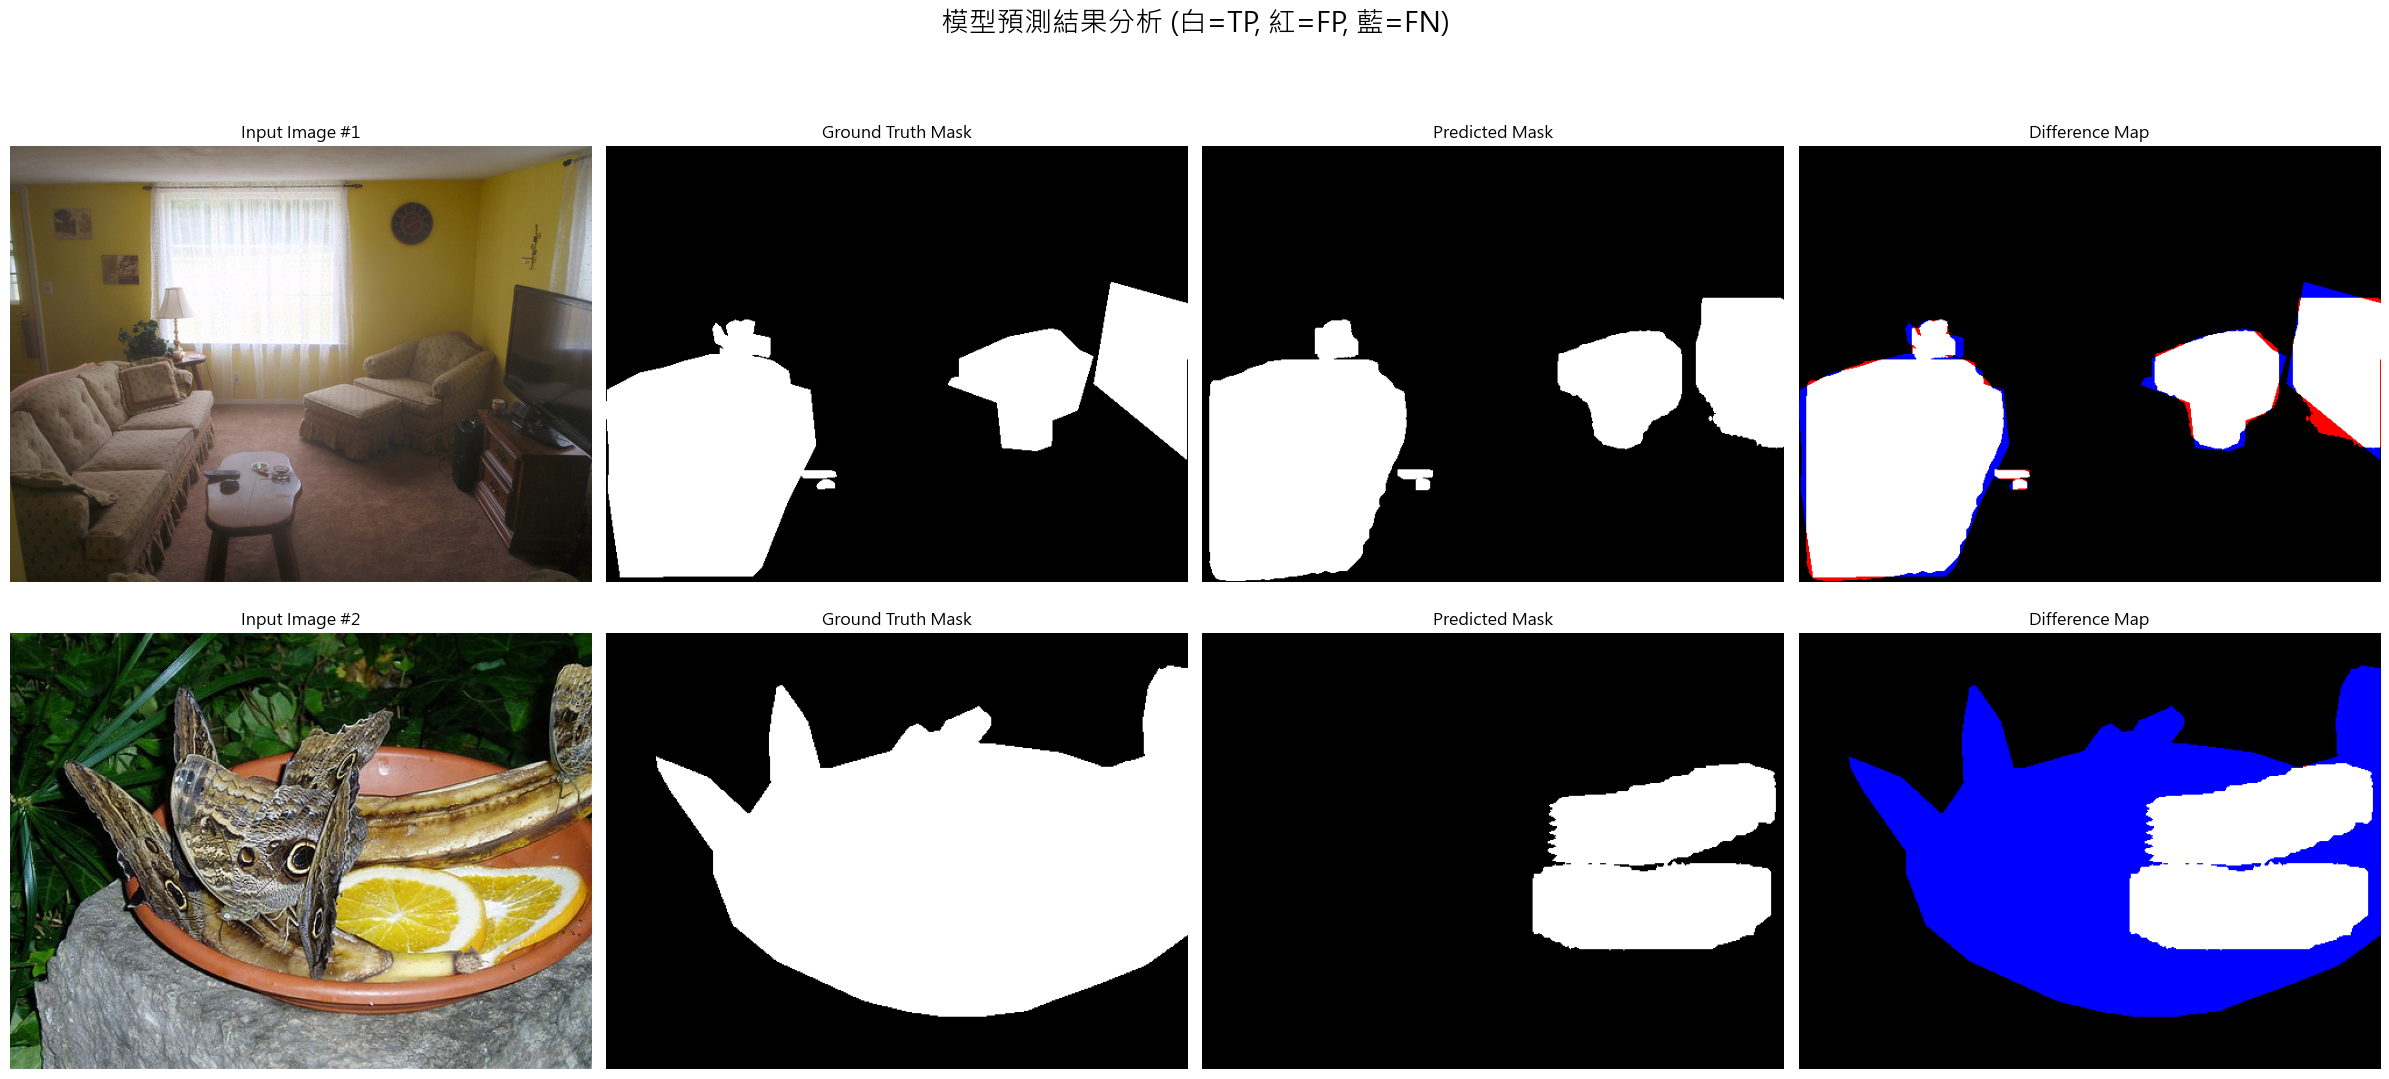

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- (請確保您的模型 model, val_loader, DEVICE, id_to_color 等都已準備好) ---

# --- 您可以修改這個數字，來決定要顯示多少個案例 ---
NUM_TO_SHOW = 4

# --- 從驗證集中找出一個包含標註的批次 ---
images, targets = None, None
for batch_images, batch_targets in data_loader:
    if any(len(t) > 0 for t in batch_targets):
        images = batch_images
        targets = batch_targets
        break

if images is None:
    print("在驗證集中找不到任何包含標註的樣本可供顯示。")
else:
    # --- 進行預測 ---
    model.eval()
    with torch.no_grad():
        images_to_device = list(img.to(DEVICE) for img in images)
        predictions = model(images_to_device)

    # --- 繪製多個結果 ---
    # 確保顯示的數量不超過批次大小
    num_to_show = min(len(images), NUM_TO_SHOW)
    fig, axes = plt.subplots(num_to_show, 4, figsize=(24, 6 * num_to_show))
    # 如果只顯示一張圖，axes 會是一維的，我們把它變成二維方便處理
    if num_to_show == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle("模型預測結果分析 (白=TP, 紅=FP, 藍=FN)", fontsize=20)

    for i in range(num_to_show):
        image = images[i]
        target = targets[i]
        prediction = predictions[i]

        # --- 準備 Ground Truth 和 Predicted Mask ---
        gt_masks_list = [coco.annToMask(ann) for ann in target]
        gt_mask_full = np.stack(gt_masks_list, axis=0).max(axis=0) if gt_masks_list else np.zeros((image.shape[1], image.shape[2]))

        pred_masks_tensor = prediction['masks'][prediction['scores'] > 0.5].cpu().squeeze(1)
        binary_masks = (pred_masks_tensor > 0.5).numpy().astype(np.uint8)
        pred_mask_full = binary_masks.max(axis=0) if binary_masks.shape[0] > 0 else np.zeros_like(gt_mask_full)

        # --- 建立差異圖 ---
        diff_map = np.zeros((gt_mask_full.shape[0], gt_mask_full.shape[1], 3), dtype=np.uint8)
        diff_map[(gt_mask_full == 1) & (pred_mask_full == 1)] = [255, 255, 255] # TP -> White
        diff_map[(gt_mask_full == 0) & (pred_mask_full == 1)] = [255, 0, 0]      # FP -> Red
        diff_map[(gt_mask_full == 1) & (pred_mask_full == 0)] = [0, 0, 255]      # FN -> Blue

        # --- 繪圖 ---
        # 1. 原始影像
        img_display = np.transpose(image.cpu().numpy(), (1, 2, 0))
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f"Input Image #{i+1}")
        
        # 2. 真實遮罩
        axes[i, 1].imshow(gt_mask_full, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")

        # 3. 預測遮罩
        axes[i, 2].imshow(pred_mask_full, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")

        # 4. 差異圖
        axes[i, 3].imshow(diff_map)
        axes[i, 3].set_title("Difference Map")
        
        # 關閉所有座標軸
        for ax in axes[i]:
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # 調整佈局以容納主標題
    plt.show()